In [4]:
import os
import requests
import pandas as pd
from astropy.io import fits
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.optimize import minimize
from scipy.interpolate import RectBivariateSpline
import emcee
import corner
import scipy.io as sio
from ipywidgets import FloatProgress
from IPython.display import display
import time

ModuleNotFoundError: No module named 'completenessContours'

In [2]:
stellarCatalog = "../stellarCatalogs/dr25_stellar_supp_gaia_clean_notimeout_GKM.txt"
pcCatalog = "koiCatalogs/dr25_GKM_PCs_notimeout.csv"
oldPcCatalog = "koiCatalogs/dr25_GKM_PCs.csv"

period_rng = (10, 700)
n_period = 100
rp_rng = (2.5,5)
n_rp = 100

# for quick tests
nWalkers = 6
nBurnin = 200
nMcmc = 1000
# for production runs
#nWalkers = 100
#nBurnin = 1000
#nMcmc = 2000


model = "dualPowerLaw"
# which Radii lets you try with planet radii corrected for Gaia radii (whichRadii = "corrected")
# or with original KOI table planet radii (whichRadii = "kic")
whichRadii = "corrected"

NameError: name 'kp' is not defined

In [3]:
def getRadii(catalog):
    if whichRadii == "corrected":
        return catalog.corrected_prad
    elif whichRadii == "kic":
        return catalog.koi_prad
    else:
        raise ValueError('Bad whichRadii string')

In [4]:
stellarTargets = pd.read_csv(stellarCatalog)
base_kois = pd.read_csv(pcCatalog)
m = (period_rng[0] <= base_kois.koi_period) & (base_kois.koi_period <= period_rng[1])
thisRadii = getRadii(base_kois)
m &= np.isfinite(thisRadii) & (rp_rng[0] <= thisRadii) & (thisRadii <= rp_rng[1])
    
kois = pd.DataFrame(base_kois[m])
allKois = pd.DataFrame(base_kois)

In [5]:
old_base_kois = pd.read_csv(oldPcCatalog)
m = (period_rng[0] <= old_base_kois.koi_period) & (old_base_kois.koi_period <= period_rng[1])
thisRadii = getRadii(old_base_kois)
m &= np.isfinite(thisRadii) & (rp_rng[0] <= thisRadii) & (thisRadii <= rp_rng[1])
    
old_kois = pd.DataFrame(old_base_kois[m])

In [6]:
kois.columns

Index(['kepid_x', 'kepoi_name', 'koi_tce_plnt_num', 'koi_pdisposition',
       'koi_score', 'koi_period', 'koi_max_mult_ev', 'koi_prad',
       'koi_prad_err1', 'koi_prad_err2', 'koi_ror', 'koi_ror_err1',
       'koi_ror_err2', 'radius', 'radius_err1', 'radius_err2', 'teff',
       'corrected_prad', 'corrected_prad_err1', 'corrected_prad_err2', 'rowid',
       'kepid_y', 'fpp_koi_period', 'fpp_prob', 'fpEffectiveness', 'obsFpRate',
       'reliability', 'fpp_prob_use', 'totalReliability'],
      dtype='object')

In [7]:
sym_diff = pd.merge(old_kois, kois, on='koi_period', indicator=True, how='outer').query('_merge == "right_only"').drop(columns=['_merge'])
sym_diff

,kepid_x_x,kepoi_name_x,koi_tce_plnt_num_x,koi_pdisposition_x,koi_score_x,koi_period,koi_max_mult_ev_x,koi_prad_x,koi_prad_err1_x,koi_prad_err2_x,...,corrected_prad_err2_y,rowid_y,kepid_y_y,fpp_koi_period_y,fpp_prob_y,fpEffectiveness_y,obsFpRate_y,reliability_y,fpp_prob_use_y,totalReliability_y
396,NaN,NaN,NaN,NaN,NaN,10.848452,NaN,NaN,NaN,NaN,...,-0.123963,768,8505670,10.848,0.000078,0.999375,3.491371e-09,1.000000,0.000078,0.999922
397,NaN,NaN,NaN,NaN,NaN,36.276124,NaN,NaN,NaN,NaN,...,-0.167392,1153,6948054,36.276,0.000013,0.999361,1.869029e-03,0.999999,0.000013,0.999986
398,NaN,NaN,NaN,NaN,NaN,34.853690,NaN,NaN,NaN,NaN,...,-0.176177,2084,9839821,34.854,0.000450,0.999336,2.970122e-03,0.999998,0.000450,0.999548
399,NaN,NaN,NaN,NaN,NaN,180.921729,NaN,NaN,NaN,NaN,...,-0.142668,2085,9839821,180.922,0.000620,0.993060,7.681284e-01,0.976849,0.000620,0.976244
400,NaN,NaN,NaN,NaN,NaN,124.922516,NaN,NaN,NaN,NaN,...,-0.746990,344,11442793,124.923,0.001400,0.998705,1.661681e-01,0.999742,0.001400,0.998342
401,NaN,NaN,NaN,NaN,NaN,59.737144,NaN,NaN,NaN,NaN,...,-0.127156,340,11442793,59.737,0.087000,0.999366,3.099135e-03,0.999998,0.087000,0.912998
402,NaN,NaN,NaN,NaN,NaN,91.940125,NaN,NaN,NaN,NaN,...,-0.121907,341,11442793,91.940,0.000550,0.999329,1.815843e-02,0.999988,0.000550,0.999438
403,NaN,NaN,NaN,NaN,NaN,21.223493,NaN,NaN,NaN,NaN,...,-0.298037,912,9146018,21.223,0.000006,0.999375,2.007878e-05,1.000000,0.000006,0.999994


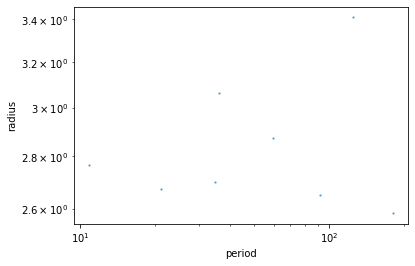

In [8]:
plt.figure()
plt.scatter(sym_diff.koi_period, sym_diff.corrected_prad_y, s=2, alpha=0.5)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('period')
plt.ylabel('radius')
plt.show()

In [9]:
print("Original stellar cuts contain %s objects" % len(kois.koi_period))
print("Fewer stellar cuts contain %s objects" % len(old_kois.koi_period))


print("\nWithout \'timoutsumry flag\' cut there are:")
print("%s objects under 6 days" % len(kois.koi_period[kois.koi_period <= 6]))
print("%s objects between 6 and 10 days" % len(kois.koi_period[(kois.koi_period <= 10) & (kois.koi_period >= 6)]))
print("%s objects between 10 and 100 days"% len(kois.koi_period[(kois.koi_period >= 10) & (kois.koi_period <= 100)]))
print("%s objects over 100 days"% len(kois.koi_period[kois.koi_period >= 100]))

print("\nOriginally there are:")
print("%s objects under 6 days" % len(old_kois.koi_period[old_kois.koi_period <= 6]))
print("%s objects between 6 and 10 days" % len(old_kois.koi_period[(old_kois.koi_period <= 10) & (old_kois.koi_period >= 6)]))
print("%s objects between 10 and 100 days"% len(old_kois.koi_period[(old_kois.koi_period >= 10) & (old_kois.koi_period <= 100)]))
print("%s objects over 100 days"% len(old_kois.koi_period[old_kois.koi_period >= 100]))

Original stellar cuts contain 404 objects
Fewer stellar cuts contain 396 objects

Without 'timoutsumry flag' cut there are:
0 objects under 6 days
0 objects between 6 and 10 days
338 objects between 10 and 100 days
66 objects over 100 days

Originally there are:
0 objects under 6 days
0 objects between 6 and 10 days
332 objects between 10 and 100 days
64 objects over 100 days


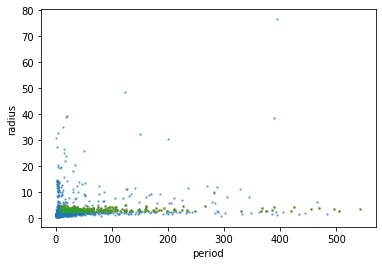

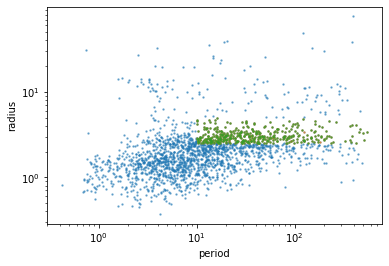

In [10]:
plt.figure()
plt.scatter(allKois.koi_period, allKois.corrected_prad, s=2, alpha=0.5)
plt.scatter(kois.koi_period, kois.corrected_prad, s=2, alpha=0.5)
plt.scatter(old_kois.koi_period, old_kois.corrected_prad, s=2, alpha=0.5)
#plt.ylim(0, 5)
plt.xlabel('period')
plt.ylabel('radius')

plt.figure()
plt.scatter(allKois.koi_period, allKois.corrected_prad, s=2, alpha=0.5)
plt.scatter(kois.koi_period, kois.corrected_prad, s=2, alpha=0.5)
plt.scatter(old_kois.koi_period, old_kois.corrected_prad, s=2, alpha=0.5)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('period')
plt.ylabel('radius')
plt.show()

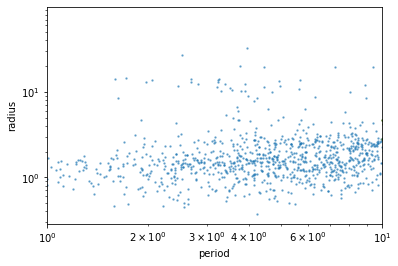

In [11]:
plt.figure()
plt.scatter(allKois.koi_period, allKois.corrected_prad, s=2, alpha=0.5)
plt.scatter(kois.koi_period, kois.corrected_prad, s=2, alpha=0.5)
plt.scatter(old_kois.koi_period, old_kois.corrected_prad, s=2, alpha=0.5)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('period')
plt.ylabel('radius')
plt.xlim(1, 10)
plt.show()

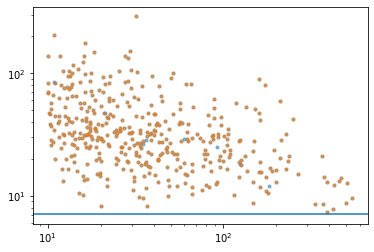

In [12]:
plt.figure()
plt.plot(kois.koi_period, kois.koi_max_mult_ev, '.', alpha=0.5)
plt.plot(old_kois.koi_period, old_kois.koi_max_mult_ev, '.', alpha=0.5)
#plt.ylim(0, 10)
plt.axhline(y=7.1)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [13]:
print("\nWithout \'timoutsumry flag\' cut there are:")
print("MES between 7.1 and 10 %s" % len(kois.koi_period[(kois.koi_max_mult_ev <= 10) & (kois.koi_max_mult_ev >= 7.1)]))
print("MES between 10 and 100 %s" % len(kois.koi_period[(kois.koi_max_mult_ev >= 10) & (kois.koi_max_mult_ev <= 100)]))
print("MES over 100 %s" % len(kois.koi_period[kois.koi_max_mult_ev >= 100]))

print("\nOriginally there are:")
print("MES between 7.1 and 10 %s" % len(old_kois.koi_period[(old_kois.koi_max_mult_ev <= 10) & (old_kois.koi_max_mult_ev >= 7.1)]))
print("MES between 10 and 100 %s" % len(old_kois.koi_period[(old_kois.koi_max_mult_ev >= 10) & (old_kois.koi_max_mult_ev <= 100)]))
print("MES over 100 %s" % len(old_kois.koi_period[old_kois.koi_max_mult_ev >= 100]))


Without 'timoutsumry flag' cut there are:
MES between 7.1 and 10 11
MES between 10 and 100 374
MES over 100 19

Originally there are:
MES between 7.1 and 10 11
MES between 10 and 100 366
MES over 100 19


404 objects


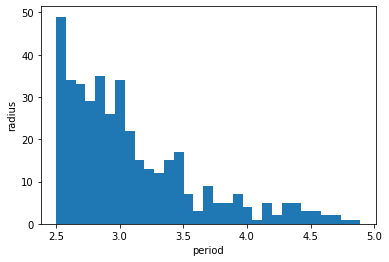

In [14]:
p = np.array(kois.koi_period.copy())
r = np.array(kois.corrected_prad.copy())

print(str(len(r)) + ' objects')
plt.figure()
c = plt.hist(r, bins=31)
#plt.axvline(x=1.8, color='g')
plt.ylabel('radius')
plt.xlabel('period')
plt.show()

n = np.array(c[0])
bin_centers = np.array([0.5*(c[1][i] + c[1][i+1]) for i in range(len(c[1])-1)])

404 objects


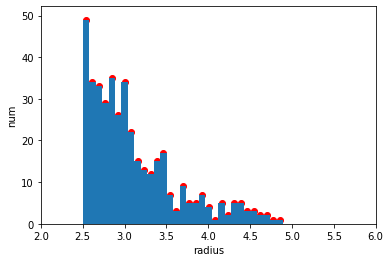

In [15]:
print(str(len(r)) + ' objects')
plt.figure()
c = plt.hist(r, bins=31)

n = np.array(c[0])
bin_centers = np.array([0.5*(c[1][i] + c[1][i+1]) for i in range(len(c[1])-1)])

plt.scatter(bin_centers, n, color='r')
#plt.axvline(x=1.8, color='g')
#plt.xscale('log')
plt.xlim(2,6)
plt.ylabel('num')
plt.xlabel('radius')
plt.show()

In [16]:
print(n)
print(bin_centers)

[49. 34. 33. 29. 35. 26. 34. 22. 15. 13. 12. 15. 17.  7.  3.  9.  5.  5.
  7.  4.  1.  5.  2.  5.  5.  3.  3.  2.  2.  1.  1.]
[2.53955984 2.6166683  2.69377676 2.77088523 2.84799369 2.92510216
 3.00221062 3.07931909 3.15642755 3.23353602 3.31064448 3.38775295
 3.46486141 3.54196988 3.61907834 3.6961868  3.77329527 3.85040373
 3.9275122  4.00462066 4.08172913 4.15883759 4.23594606 4.31305452
 4.39016299 4.46727145 4.54437991 4.62148838 4.69859684 4.77570531
 4.85281377]


[-33.01135059 124.47066383]
404 objects
[49. 34. 33. 29. 35. 26. 34. 22. 15. 13. 12. 15. 17.  7.  3.  9.  5.  5.
  7.  4.  1.  5.  2.  5.  5.  3.  3.  2.  2.  1.  1.]


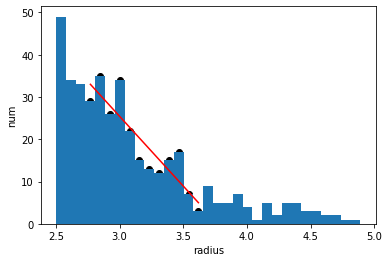

In [17]:
from scipy.optimize import curve_fit

def line(x, m, b):
    return(m*x + b)

popt, pcov = curve_fit(line, bin_centers[3:15], n[3:15])
print(popt)

print(str(len(r)) + ' objects')
plt.figure()
c = plt.hist(r, bins=31)

n = np.array(c[0])
bin_centers = np.array([0.5*(c[1][i] + c[1][i+1]) for i in range(len(c[1])-1)])
print(n)

plt.plot(bin_centers[3:15], line(bin_centers[3:15], *popt), 'r-')
plt.scatter(bin_centers[3:15], n[3:15], color='k')
#plt.axvline(x=1.8, color='g')
#plt.xscale('log')
plt.ylabel('num')
plt.xlabel('radius')
plt.show()

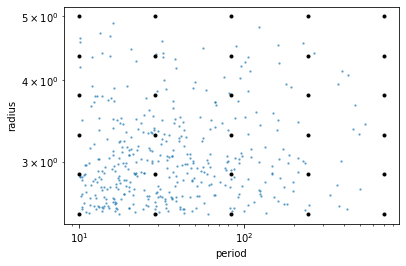

In [18]:
period = np.logspace(np.log10(10), np.log10(700), num=5)
radius = np.logspace(np.log10(2.5), np.log10(5), num=6)
pgrid, rgrid = np.meshgrid(period, radius, indexing="ij")

plt.figure()
plt.scatter(kois.koi_period, kois.corrected_prad, s=2, alpha=0.5)
plt.plot(pgrid.flat, rgrid.flat, ".k")
plt.yscale('log')
plt.xscale('log')
plt.xlabel('period')
plt.ylabel('radius')
plt.show()

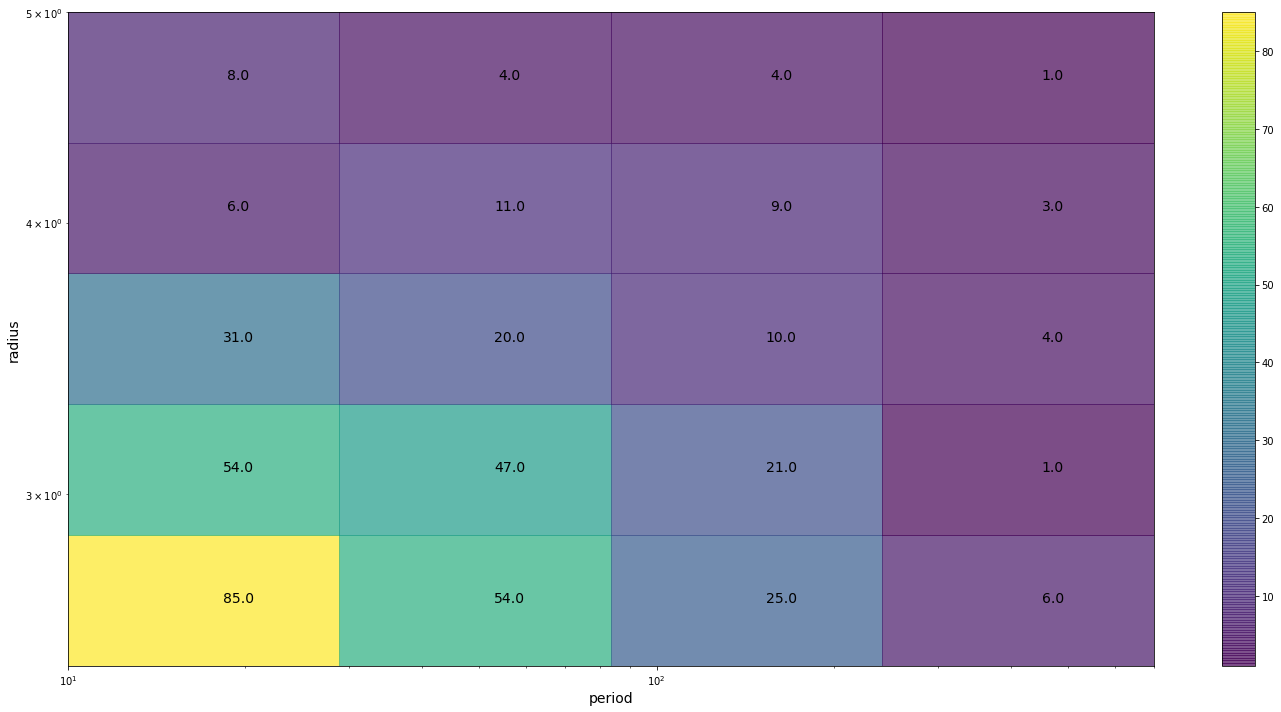

In [19]:
H, xedges, yedges = np.histogram2d(kois.koi_period, kois.corrected_prad, bins=(period, radius))
xcent = 0.5 * (xedges[1:] + xedges[:-1])
ycent = 0.5 * (yedges[1:] + yedges[:-1])

fig, ax = plt.subplots(figsize=(20, 10))
im = ax.pcolormesh(pgrid, rgrid, H, alpha=0.7)


for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
        ax.text(xcent[j],ycent[i], H.T[i,j], 
                color="k", ha="center", va="center", fontsize=14)

fig.colorbar(im)
plt.xlabel('period', fontsize=14)
plt.ylabel('radius', fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.savefig('../loguniform_labelled.png', dpi=300)
plt.tight_layout()
plt.show()